<a href="https://colab.research.google.com/github/Ashish1999Kumar/Deep-learning/blob/master/0407_VectorisedGDAlgorithms_1554564131433.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import tqdm_notebook 
import seaborn as sns
import imageio
import time
from IPython.display import HTML


from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs

In [0]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

In [0]:
np.random.seed(0)

## Generate data

In [117]:
data, labels = make_blobs(n_samples=1000, centers=4, n_features=2, random_state=0)
print(data.shape, labels.shape)

(1000, 2) (1000,)


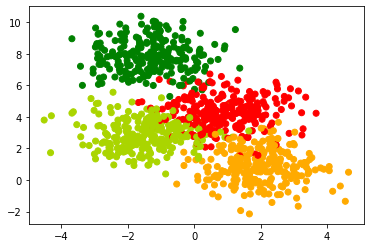

In [118]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

In [0]:
labels_orig = labels
labels = np.mod(labels_orig, 2)

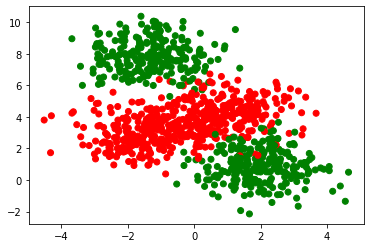

In [120]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

## Multi class classification

In [121]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels_orig, stratify=labels_orig, random_state=0)
print(X_train.shape, X_val.shape, labels_orig.shape)

(750, 2) (250, 2) (1000,)


In [122]:
enc = OneHotEncoder()
# 0 -> (1, 0, 0, 0), 1 -> (0, 1, 0, 0), 2 -> (0, 0, 1, 0), 3 -> (0, 0, 0, 1)
y_OH_train = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
y_OH_val = enc.fit_transform(np.expand_dims(Y_val,1)).toarray()
print(y_OH_train.shape, y_OH_val.shape)

(750, 4) (250, 4)


In [123]:
W1 = np.random.randn(2,2)
W2 = np.random.randn(2,4)
print(W1)
print(W2)

[[1.76405235 0.40015721]
 [0.97873798 2.2408932 ]]
[[ 1.86755799 -0.97727788  0.95008842 -0.15135721]
 [-0.10321885  0.4105985   0.14404357  1.45427351]]


## FF Class

In [0]:
class FFNetwork:
  
  def __init__(self, W1, W2):
        
    self.params={}
    self.params["W1"]=W1.copy()
    self.params["W2"]=W2.copy()
    self.params["B1"]=np.zeros((1,2))
    self.params["B2"]=np.zeros((1,4))
    self.num_layers=2
    self.gradients={}
    self.update_params={}
    self.prev_update_params={}
    for i in range(1,self.num_layers+1):
      self.update_params["v_w"+str(i)]=0
      self.update_params["v_b"+str(i)]=0
      self.update_params["m_b"+str(i)]=0
      self.update_params["m_w"+str(i)]=0
      self.prev_update_params["v_w"+str(i)]=0
      self.prev_update_params["v_b"+str(i)]=0
  
  def forward_activation(self, X): 
    return 1.0/(1.0 + np.exp(-X))
      
  def grad_activation(self, X):
    return X*(1-X) 

  def softmax(self, X):
    exps = np.exp(X)
    return exps / np.sum(exps, axis=1).reshape(-1,1)
  
  def forward_pass(self, X, params = None):
    if params is None:
        params = self.params
    self.A1 = np.matmul(X, params["W1"]) + params["B1"] # (N, 2) * (2, 2) -> (N, 2)
    self.H1 = self.forward_activation(self.A1) # (N, 2)
    self.A2 = np.matmul(self.H1, params["W2"]) + params["B2"] # (N, 2) * (2, 4) -> (N, 4)
    self.H2 = self.softmax(self.A2) # (N, 4)
    return self.H2
  
  def grad(self, X, Y, params = None):
    if params is None:
      params = self.params 
      
    self.forward_pass(X, params)
    m = X.shape[0]
    self.gradients["dA2"] = self.H2 - Y # (N, 4) - (N, 4) -> (N, 4)
    self.gradients["dW2"] = np.matmul(self.H1.T, self.gradients["dA2"]) # (2, N) * (N, 4) -> (2, 4)
    self.gradients["dB2"] = np.sum(self.gradients["dA2"], axis=0).reshape(1, -1) # (N, 4) -> (1, 4)
    self.gradients["dH1"] = np.matmul(self.gradients["dA2"], params["W2"].T) # (N, 4) * (4, 2) -> (N, 2)
    self.gradients["dA1"] = np.multiply(self.gradients["dH1"], self.grad_activation(self.H1)) # (N, 2) .* (N, 2) -> (N, 2)
    self.gradients["dW1"] = np.matmul(X.T, self.gradients["dA1"]) # (2, N) * (N, 2) -> (2, 2)
    self.gradients["dB1"] = np.sum(self.gradients["dA1"], axis=0).reshape(1, -1) # (N, 2) -> (1, 2)
    
  def fit(self, X, Y, epochs=1, algo= "GD", display_loss=False, 
          eta=1, mini_batch_size=100, eps=1e-8,  
          beta=0.9, beta1=0.9, beta2=0.9, gamma=0.9 ):
      
    if display_loss:
      loss = {}
    for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      m = X.shape[0]
      
      if algo == "GD":
        self.grad(X, Y)
        for i in range(1,self.num_layers+1):
          self.params["W"+str(i)] -= eta * (self.gradients["dW"+str(i)]/m)
          self.params["B"+str(i)] -= eta * (self.gradients["dB"+str(i)]/m)
          
      elif algo == "MiniBatch":
        for k in range(0,m,mini_batch_size):
          self.grad(X[k:k+mini_batch_size], Y[k:k+mini_batch_size])
          for i in range(1,self.num_layers+1):
            self.params["W"+str(i)] -= eta * (self.gradients["dW"+str(i)]/mini_batch_size)
            self.params["B"+str(i)] -= eta * (self.gradients["dB"+str(i)]/mini_batch_size)
            
      elif algo == "Momentum":
        self.grad(X, Y)
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)] = gamma *self.update_params["v_w"+str(i)] + eta * (self.gradients["dW"+str(i)]/m)
          self.update_params["v_b"+str(i)] = gamma *self.update_params["v_b"+str(i)] + eta * (self.gradients["dB"+str(i)]/m)
          self.params["W"+str(i)] -= self.update_params["v_w"+str(i)]
          self.params["B"+str(i)] -= self.update_params["v_b"+str(i)]  
          
      elif algo == "NAG":
        temp_params = {}
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)]=gamma*self.prev_update_params["v_w"+str(i)]
          self.update_params["v_b"+str(i)]=gamma*self.prev_update_params["v_b"+str(i)]
          temp_params["W"+str(i)]=self.params["W"+str(i)]-self.update_params["v_w"+str(i)]
          temp_params["B"+str(i)]=self.params["B"+str(i)]-self.update_params["v_b"+str(i)]
        self.grad(X,Y,temp_params)
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)] = gamma *self.update_params["v_w"+str(i)] + eta * (self.gradients["dW"+str(i)]/m)
          self.update_params["v_b"+str(i)] = gamma *self.update_params["v_b"+str(i)] + eta * (self.gradients["dB"+str(i)]/m)
          self.params["W"+str(i)] -= eta * (self.update_params["v_w"+str(i)])
          self.params["B"+str(i)] -= eta * (self.update_params["v_b"+str(i)]) 
        self.prev_update_params=self.update_params 
        
      elif algo == "AdaGrad":
        self.grad(X, Y)
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)] += (self.gradients["dW"+str(i)]/m)**2
          self.update_params["v_b"+str(i)] += (self.gradients["dB"+str(i)]/m)**2
          self.params["W"+str(i)] -= (eta/(np.sqrt(self.update_params["v_w"+str(i)])+eps)) * (self.gradients["dW"+str(i)]/m)
          self.params["B"+str(i)] -= (eta/(np.sqrt(self.update_params["v_b"+str(i)])+eps)) * (self.gradients["dB"+str(i)]/m)
      
      elif algo == "RMSProp":
        self.grad(X, Y)
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)] = beta*self.update_params["v_w"+str(i)] +(1-beta)*((self.gradients["dW"+str(i)]/m)**2)
          self.update_params["v_b"+str(i)] = beta*self.update_params["v_b"+str(i)] +(1-beta)*((self.gradients["dB"+str(i)]/m)**2)
          self.params["W"+str(i)] -= (eta/(np.sqrt(self.update_params["v_w"+str(i)]+eps)))*(self.gradients["dW"+str(i)]/m)
          self.params["B"+str(i)] -= (eta/(np.sqrt(self.update_params["v_b"+str(i)]+eps)))*(self.gradients["dB"+str(i)]/m)
      
      elif algo == "Adam":
        self.grad(X, Y)
        num_updates=0
        for i in range(1,self.num_layers+1):
          num_updates+=1
          self.update_params["m_w"+str(i)]=beta1*self.update_params["m_w"+str(i)]+(1-beta1)*(self.gradients["dW"+str(i)]/m)
          self.update_params["v_w"+str(i)]=beta2*self.update_params["v_w"+str(i)]+(1-beta2)*((self.gradients["dW"+str(i)]/m)**2)
          m_w_hat=self.update_params["m_w"+str(i)]/(1-np.power(beta1,num_updates))
          v_w_hat=self.update_params["v_w"+str(i)]/(1-np.power(beta2,num_updates))
          self.params["W"+str(i)] -=(eta/np.sqrt(v_w_hat+eps))*m_w_hat
          
          self.update_params["m_b"+str(i)]=beta1*self.update_params["m_b"+str(i)]+(1-beta1)*(self.gradients["dB"+str(i)]/m)
          self.update_params["v_b"+str(i)]=beta2*self.update_params["v_b"+str(i)]+(1-beta2)*((self.gradients["dB"+str(i)]/m)**2)
          m_b_hat=self.update_params["m_b"+str(i)]/(1-np.power(beta1,num_updates))
          v_b_hat=self.update_params["v_b"+str(i)]/(1-np.power(beta2,num_updates))
          self.params["B"+str(i)] -=(eta/np.sqrt(v_b_hat+eps))*m_b_hat
      if display_loss:
        Y_pred = self.predict(X)
        loss[num_epoch] = log_loss(np.argmax(Y, axis=1), Y_pred)
    
    if display_loss:
      plt.plot(np.array(list(loss.values())).astype(float), '-o', markersize=5)
      plt.xlabel('Epochs')
      plt.ylabel('Log Loss')
      plt.show()
      
  
  def predict(self, X):
    Y_pred = self.forward_pass(X)
    return np.array(Y_pred).squeeze()

In [0]:
def print_accuracy():    
    Y_pred_train = model.predict(X_train)
    Y_pred_train = np.argmax(Y_pred_train,1)
    Y_pred_val = model.predict(X_val)
    Y_pred_val = np.argmax(Y_pred_val,1)
    accuracy_train = accuracy_score(Y_pred_train, Y_train)
    accuracy_val = accuracy_score(Y_pred_val, Y_val)
    print("Training accuracy", round(accuracy_train, 4))
    print("Validation accuracy", round(accuracy_val, 4))
    
    if False:
      plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_train, cmap=my_cmap, s=15*(np.abs(np.sign(Y_pred_train-Y_train))+.1))
      plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


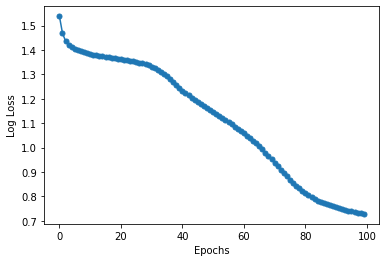

Training accuracy 0.7053
Validation accuracy 0.716
CPU times: user 319 ms, sys: 3.18 ms, total: 322 ms
Wall time: 332 ms


In [126]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="GD", display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


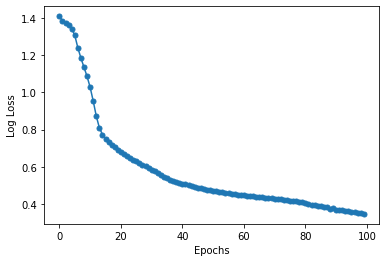

Training accuracy 0.8867
Validation accuracy 0.904
CPU times: user 364 ms, sys: 7.99 ms, total: 372 ms
Wall time: 374 ms


In [127]:

%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="MiniBatch", mini_batch_size=128, display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


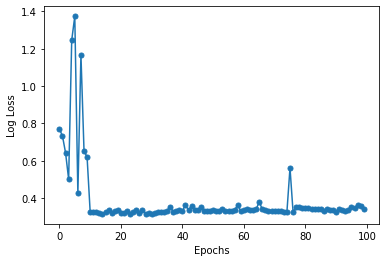

Training accuracy 0.8693
Validation accuracy 0.876
CPU times: user 977 ms, sys: 8.59 ms, total: 985 ms
Wall time: 992 ms


In [128]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="MiniBatch", mini_batch_size=8, display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


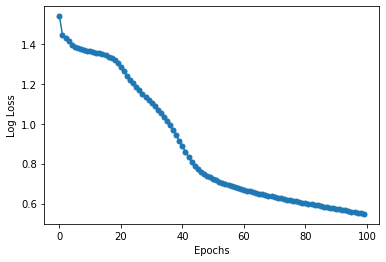

Training accuracy 0.8387
Validation accuracy 0.852
CPU times: user 330 ms, sys: 9.9 ms, total: 340 ms
Wall time: 344 ms


In [129]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="Momentum", gamma=0.5, display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


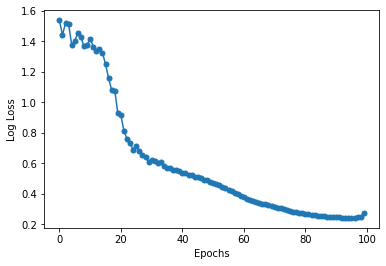

Training accuracy 0.8947
Validation accuracy 0.916
CPU times: user 337 ms, sys: 4.17 ms, total: 341 ms
Wall time: 352 ms


In [130]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="Momentum", gamma=0.9, display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


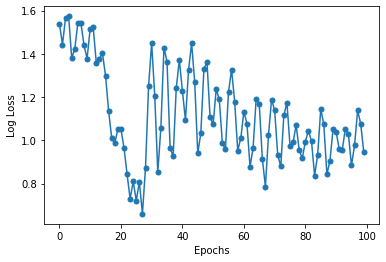

Training accuracy 0.6347
Validation accuracy 0.66
CPU times: user 318 ms, sys: 2.88 ms, total: 321 ms
Wall time: 334 ms


In [131]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="Momentum", gamma=0.99, display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


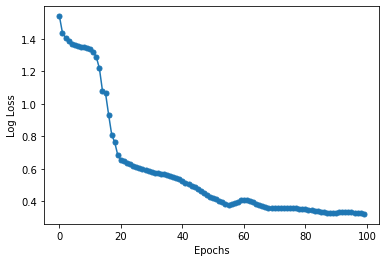

Training accuracy 0.88
Validation accuracy 0.872
CPU times: user 314 ms, sys: 11.2 ms, total: 325 ms
Wall time: 334 ms


In [132]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="NAG", gamma=0.99, display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


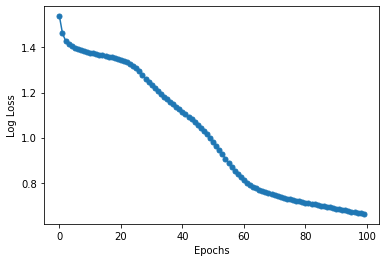

Training accuracy 0.704
Validation accuracy 0.728
CPU times: user 304 ms, sys: 5.92 ms, total: 310 ms
Wall time: 333 ms


In [133]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="NAG", gamma=0.5, display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


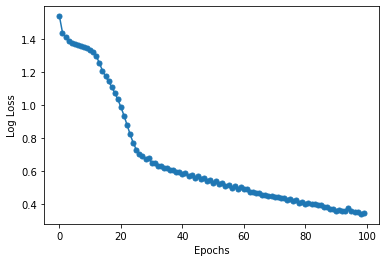

Training accuracy 0.8773
Validation accuracy 0.9
CPU times: user 311 ms, sys: 7.26 ms, total: 318 ms
Wall time: 335 ms


In [134]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="NAG", gamma=0.9, display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


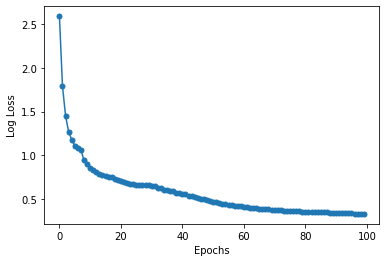

Training accuracy 0.88
Validation accuracy 0.904
CPU times: user 318 ms, sys: 4.93 ms, total: 322 ms
Wall time: 337 ms


In [135]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="AdaGrad", display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


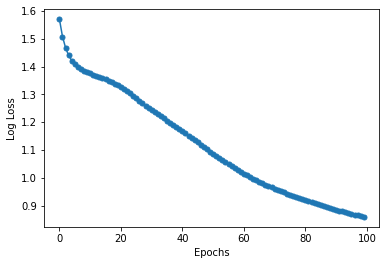

Training accuracy 0.644
Validation accuracy 0.636
CPU times: user 426 ms, sys: 7.86 ms, total: 434 ms
Wall time: 448 ms


In [136]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=.1, algo="AdaGrad", display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


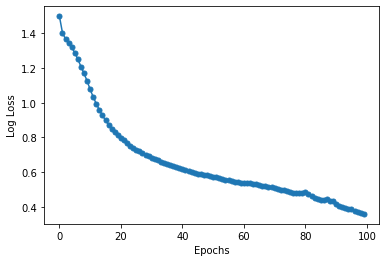

Training accuracy 0.8827
Validation accuracy 0.908
CPU times: user 346 ms, sys: 9.07 ms, total: 355 ms
Wall time: 370 ms


In [137]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=.1, algo="RMSProp", beta=0.9, display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


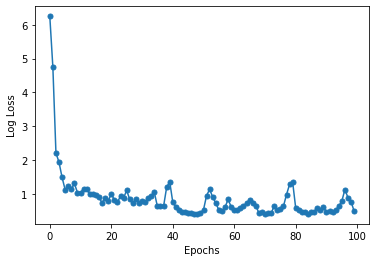

Training accuracy 0.8453
Validation accuracy 0.844
CPU times: user 325 ms, sys: 7.05 ms, total: 332 ms
Wall time: 333 ms


In [138]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=.9, algo="RMSProp", beta=0.9, display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


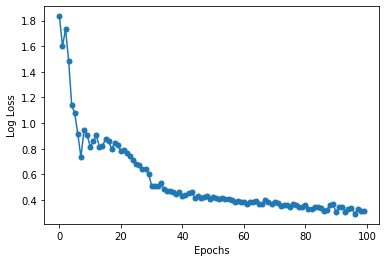

Training accuracy 0.8973
Validation accuracy 0.884
CPU times: user 331 ms, sys: 11 ms, total: 342 ms
Wall time: 341 ms


In [139]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=.9, algo="Adam", beta=0.9, display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


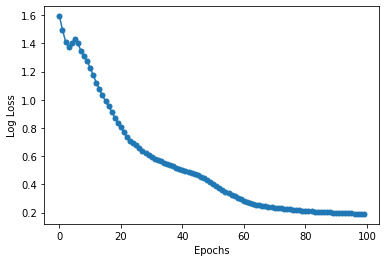

Training accuracy 0.9227
Validation accuracy 0.94
CPU times: user 345 ms, sys: 6.17 ms, total: 351 ms
Wall time: 367 ms


In [140]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=.1, algo="Adam", beta=0.9, display_loss=True)
print_accuracy()

## Good configurations with each algo

In [256]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=1000, eta=0.5, algo="GD", display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


ValueError: ignored

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


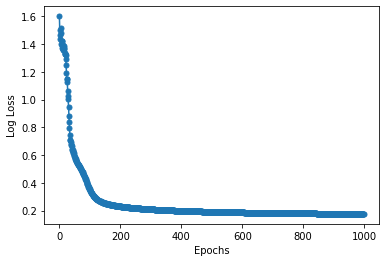

Training accuracy 0.9267
Validation accuracy 0.944
CPU times: user 1.61 s, sys: 12.6 ms, total: 1.62 s
Wall time: 1.64 s


In [142]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=1000, eta=0.5, algo="Momentum", gamma=0.9, display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


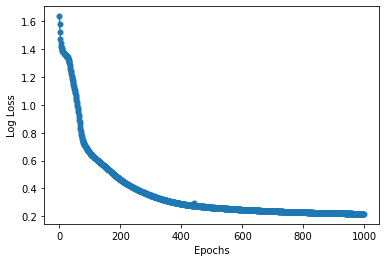

Training accuracy 0.9213
Validation accuracy 0.94
CPU times: user 1.61 s, sys: 17 ms, total: 1.63 s
Wall time: 1.65 s


In [143]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=1000, eta=0.5, algo="NAG", gamma=0.9, display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


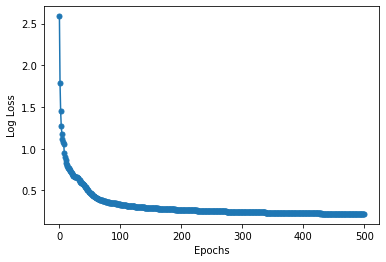

Training accuracy 0.912
Validation accuracy 0.936
CPU times: user 885 ms, sys: 19 ms, total: 904 ms
Wall time: 921 ms


In [144]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=500, eta=1, algo="AdaGrad", display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


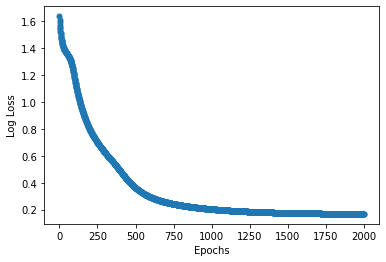

Training accuracy 0.9253
Validation accuracy 0.94
CPU times: user 3.13 s, sys: 33.6 ms, total: 3.16 s
Wall time: 3.19 s


In [145]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=2000, eta=.01, algo="RMSProp", beta=0.9, display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


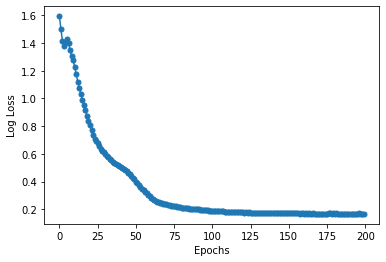

Training accuracy 0.9293
Validation accuracy 0.952
CPU times: user 488 ms, sys: 3.99 ms, total: 492 ms
Wall time: 513 ms


In [146]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=200, eta=.1, algo="Adam", beta=0.9, display_loss=True)
print_accuracy()

Exercise

0. Duplicate this exercise for our smaller network with 3 neurons (binary classification). In this case, you can practise writing the vectorised form of the gradient descent. 

1. After training for a few epochs, freeze updates to all variables, except two (say w_1 and w_2 in our diagram). Now we have a situation similar to the previous setting (where there are two variables and we can plot 2d and 3d plots). Plot the error surface and animate to visualise each algorithm. 

2. Try 1. with different parameters (say w_3, b_2) and observe how the algorithms work


In [0]:
from sklearn.datasets import make_moons

In [0]:
data_moon,label_moon=make_moons(n_samples=1000,noise=0.1,random_state=1)

In [149]:
print(data.shape)

(1000, 2)


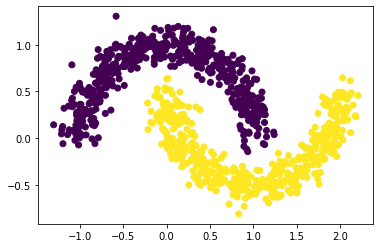

In [150]:
plt.scatter(data_moon[:,0],data_moon[:,1],c=label_moon)

In [0]:
x_train_m,x_test_m,y_train_m,y_test_m=train_test_split(data_moon,label_moon,stratify=label_moon,test_size=0.2,random_state=1)

In [152]:
print(x_train_m.shape,y_train_m.shape)

(800, 2) (800,)


In [0]:
W1=np.random.randn(2,2)
W2=np.random.randn(2,2)

In [154]:
end=OneHotEncoder()
y_train_moh=end.fit_transform(np.expand_dims(y_train_m,1)).toarray()
y_test_moh=end.fit_transform(np.expand_dims(y_test_m,1)).toarray()
print(y_train_moh.shape,y_test_moh.shape)

(800, 2) (200, 2)


In [0]:
class VectorisedGDALgo:
  def __init__(self,W1,W2):
    self.params={}
    self.params["W1"]=W1.copy()
    self.params["W2"]=W2.copy()
    self.params["B1"]=np.zeros((1,2))
    self.params["B2"]=np.zeros((1,2))
    self.gradients={}
    self.update_params={}
    self.prev_update_params={}
    for i in range(1,3):
      self.update_params["v_w"+str(i)]=0
      self.update_params["v_b"+str(i)]=0
      self.update_params["m_w"+str(i)]=0
      self.update_params["m_b"+str(i)]=0
      self.prev_update_params["v_w"+str(i)]=0
      self.prev_update_params["v_b"+str(i)]=0
  
  def sigmoid(self,X):
    return 1/(1+np.exp(-X))
  
  def softmax(self,X):
    return np.exp(X)/np.sum(np.exp(X),axis=1).reshape(-1,1)

  def activation(self,X):
    return X*(1-X)
  
  def forward_act(self,X):
    self.A1=np.matmul(X,self.params["W1"])+self.params["B1"]
    self.H1=self.sigmoid(self.A1)
    self.A2=np.matmul(self.H1,self.params["W2"])+self.params["B2"]
    self.H2=self.softmax(self.A2)
    return self.H2

  def BackProp_act(self,X,Y):
    self.forward_act(X)
    m=X.shape[0]
    self.gradients["dA2"]=self.H2-Y
    self.gradients["dW2"]=np.matmul(self.H1.T,self.gradients["dA2"])
    self.gradients["dB2"]=np.sum(self.gradients["dA2"],axis=0).reshape(1,-1)
    self.gradients["dH1"] = np.matmul(self.gradients["dA2"], self.params["W2"].T)
    self.gradients["dA1"] = np.multiply(self.gradients["dH1"], self.activation(self.H1)) 
    self.gradients["dW1"] = np.matmul(X.T, self.gradients["dA1"]) 
    self.gradients["dB1"] = np.sum(self.gradients["dA1"], axis=0).reshape(1, -1)

  def fit(self,X,Y,lr=1,epochs=3000,beta=0.9,eps=1e-8,algo="GD",batch=2,gamma=0.9,beta1=0.9,beta2=0.9):
    loss={}
    for num_epochs in tqdm_notebook(range(epochs),total=epochs,unit="epochs"):
      m=X.shape[0]
      if algo=="GD":
        self.BackProp_act(X,Y)
        for i in range(1,3):
          self.params["W"+str(i)]-=lr*(self.gradients["dW"+str(i)]/m)
          self.params["B"+str(i)]-=lr*(self.gradients["dB"+str(i)]/m)
      elif algo=="MiniBatch":
        for k in range(0,m,batch):
          self.BackProp_act(X[k:k+batch], Y[k:k+batch])
          for i in range(1,3):
            self.params["W"+str(i)]-=lr*(self.gradients["dW"+str(i)]/batch)
            self.params["B"+str(i)]-=lr*(self.gradients["dB"+str(i)]/batch)
      
      elif algo=="Momentum":
        self.BackProp_act(X,Y)
        for i in range(1,3):
          self.update_params["v_w"+str(i)]=(gamma*self.update_params["v_w"+str(i)]+lr*self.gradients["dW"+str(i)])/m
          self.update_params["v_b"+str(i)]=(gamma*self.update_params["v_b"+str(i)]+lr*self.gradients["dB"+str(i)])/m
          self.params["W"+str(i)]-=self.update_params["v_w"+str(i)]
          self.params["B"+str(i)]-=self.update_params["v_b"+str(i)]
      
      elif algo=="Adagrad":
        self.BackProp_act(X,Y)
        for i in range(1,3):
          self.update_params["v_w"+str(i)]=self.update_params["v_w"+str(i)]+(self.gradients["dW"+str(i)]/m)**2
          self.update_params["v_b"+str(i)]=self.update_params["v_b"+str(i)]+(self.gradients["dB"+str(i)]/m)**2
          self.params["W"+str(i)]-=(lr*(self.gradients["dW"+str(i)]/m))/np.sqrt(self.update_params["v_w"+str(i)]+eps)
          self.params["B"+str(i)]-=(lr*(self.gradients["dB"+str(i)]/m))/np.sqrt(self.update_params["v_b"+str(i)]+eps)
      
      elif algo=="RMSprop":
        self.BackProp_act(X,Y)
        for i in range(1,3):
          self.update_params["v_w"+str(i)]=beta*self.update_params["v_w"+str(i)]+(1-beta)*(self.gradients["dW"+str(i)]/m)**2
          self.update_params["v_b"+str(i)]=beta*self.update_params["v_b"+str(i)]+(1-beta)*(self.gradients["dB"+str(i)]/m)**2
          self.params["W"+str(i)]-=(lr*(self.gradients["dW"+str(i)]/m))/np.sqrt(self.update_params["v_w"+str(i)]+eps)
          self.params["B"+str(i)]-=(lr*(self.gradients["dB"+str(i)]/m))/np.sqrt(self.update_params["v_b"+str(i)]+eps) 

      elif algo=="Adam":       
        self.BackProp_act(X, Y)
        num_updates=0
        for i in range(1,3):
          num_updates+=1
          self.update_params["m_w"+str(i)]=beta1*self.update_params["m_w"+str(i)]+(1-beta1)*(self.gradients["dW"+str(i)]/m)
          self.update_params["v_w"+str(i)]=beta2*self.update_params["v_w"+str(i)]+(1-beta2)*((self.gradients["dW"+str(i)]/m)**2)
          m_w_hat=self.update_params["m_w"+str(i)]/(1-np.power(beta1,num_updates))
          v_w_hat=self.update_params["v_w"+str(i)]/(1-np.power(beta2,num_updates))
          self.params["W"+str(i)] -=(lr/np.sqrt(v_w_hat+eps))*m_w_hat
        
          self.update_params["m_b"+str(i)]=beta1*self.update_params["m_b"+str(i)]+(1-beta1)*(self.gradients["dB"+str(i)]/m)
          self.update_params["v_b"+str(i)]=beta2*self.update_params["v_b"+str(i)]+(1-beta2)*((self.gradients["dB"+str(i)]/m)**2)
          m_b_hat=self.update_params["m_b"+str(i)]/(1-np.power(beta1,num_updates))
          v_b_hat=self.update_params["v_b"+str(i)]/(1-np.power(beta2,num_updates))
          self.params["B"+str(i)] -=(lr/np.sqrt(v_b_hat+eps))*m_b_hat

      Y_pred = self.predict(X)
      loss[num_epochs] = log_loss(np.argmax(Y, axis=1), Y_pred)
    
    plt.plot(np.array(list(loss.values())).astype(float), '-o', markersize=2)
    plt.xlabel('Epochs')
    plt.ylabel('Log Loss')
    plt.show()
        
  def predict(self,X):
    y=self.forward_act(X)
    return np.array(y).squeeze()



In [0]:
def print_accuracy():    
    Y_pred_train = model.predict(x_train_m)
    Y_pred_train = np.argmax(Y_pred_train,1)
    Y_pred_val = model.predict(x_test_m)
    Y_pred_val = np.argmax(Y_pred_val,1)
    accuracy_train = accuracy_score(Y_pred_train, y_train_m)
    accuracy_val = accuracy_score(Y_pred_val, y_test_m)
    print("Training accuracy", round(accuracy_train, 4))
    print("Validation accuracy", round(accuracy_val, 4))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


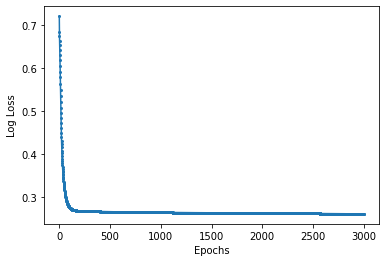

Training accuracy 0.8738
Validation accuracy 0.88


In [270]:
model=VectorisedGDALgo(W1,W2)
model.fit(x_train_m,y_train_moh,algo="GD")
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


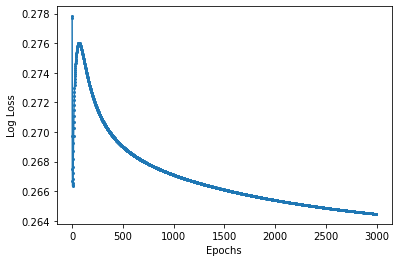

Training accuracy 0.8725
Validation accuracy 0.895


In [271]:
model=VectorisedGDALgo(W1,W2)
model.fit(x_train_m,y_train_moh,algo="MiniBatch")
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


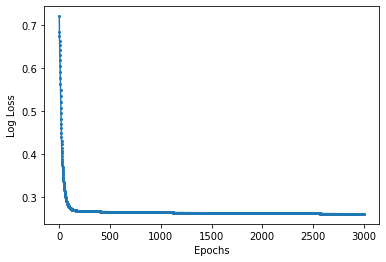

Training accuracy 0.8738
Validation accuracy 0.88


In [272]:
model=VectorisedGDALgo(W1,W2)
model.fit(x_train_m,y_train_moh,algo="Momentum")
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


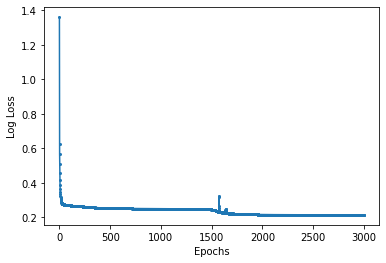

Training accuracy 0.8975
Validation accuracy 0.905


In [273]:
model=VectorisedGDALgo(W1,W2)
model.fit(x_train_m,y_train_moh,algo="Adagrad")
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


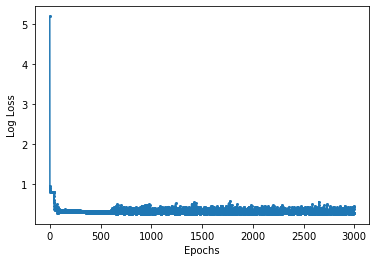

Training accuracy 0.9012
Validation accuracy 0.89


In [274]:
model=VectorisedGDALgo(W1,W2)
model.fit(x_train_m,y_train_moh,algo="RMSprop")
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


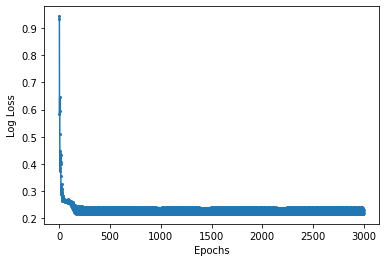

Training accuracy 0.8875
Validation accuracy 0.895


In [275]:
model=VectorisedGDALgo(W1,W2)
model.fit(x_train_m,y_train_moh,algo="Adam")
print_accuracy()